In [2]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [3]:
# Load dataset with error handling
file_path = "german_credit_data.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File '{file_path}' not found.")
    
df = pd.read_csv(file_path)
df_original = df.copy()


In [4]:
# Numeric summary for numeric columns
print(df.describe())

# Count of unique values for categorical columns
categorical_cols = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())

        Unnamed: 0          Age          Job  Credit amount     Duration
count  1000.000000  1000.000000  1000.000000    1000.000000  1000.000000
mean    499.500000    35.546000     1.904000    3271.258000    20.903000
std     288.819436    11.375469     0.653614    2822.736876    12.058814
min       0.000000    19.000000     0.000000     250.000000     4.000000
25%     249.750000    27.000000     2.000000    1365.500000    12.000000
50%     499.500000    33.000000     2.000000    2319.500000    18.000000
75%     749.250000    42.000000     2.000000    3972.250000    24.000000
max     999.000000    75.000000     3.000000   18424.000000    72.000000

Value counts for Sex:
Sex
male      690
female    310
Name: count, dtype: int64

Value counts for Job:
Job
2    630
1    200
3    148
0     22
Name: count, dtype: int64

Value counts for Housing:
Housing
own     713
rent    179
free    108
Name: count, dtype: int64

Value counts for Saving accounts:
Saving accounts
little        603
moderat

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")  # Updated syntax
%matplotlib inline



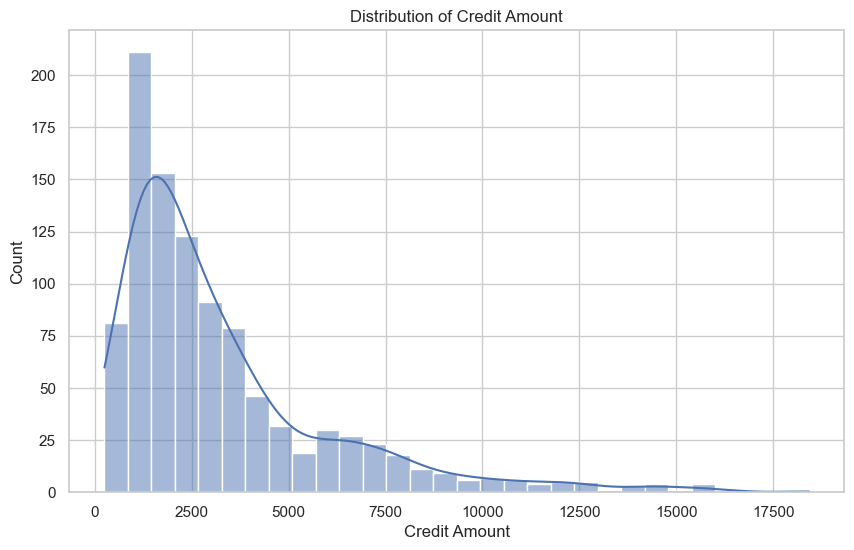

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Credit amount", bins=30, kde=True)
plt.title("Distribution of Credit Amount")
plt.xlabel("Credit Amount")
plt.ylabel("Count")
plt.show()


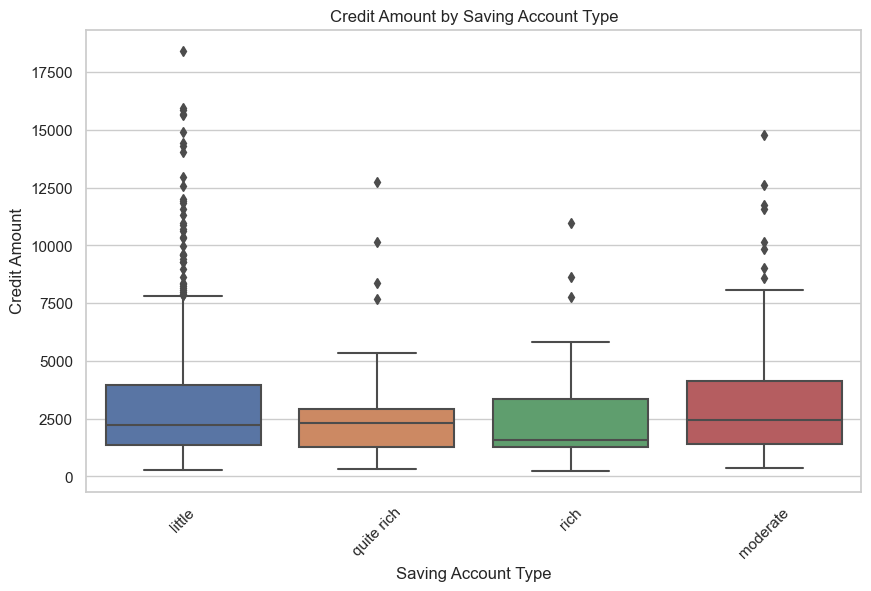

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Saving accounts", y="Credit amount")
plt.title("Credit Amount by Saving Account Type")
plt.xlabel("Saving Account Type")
plt.ylabel("Credit Amount")
plt.xticks(rotation=45)
plt.show()


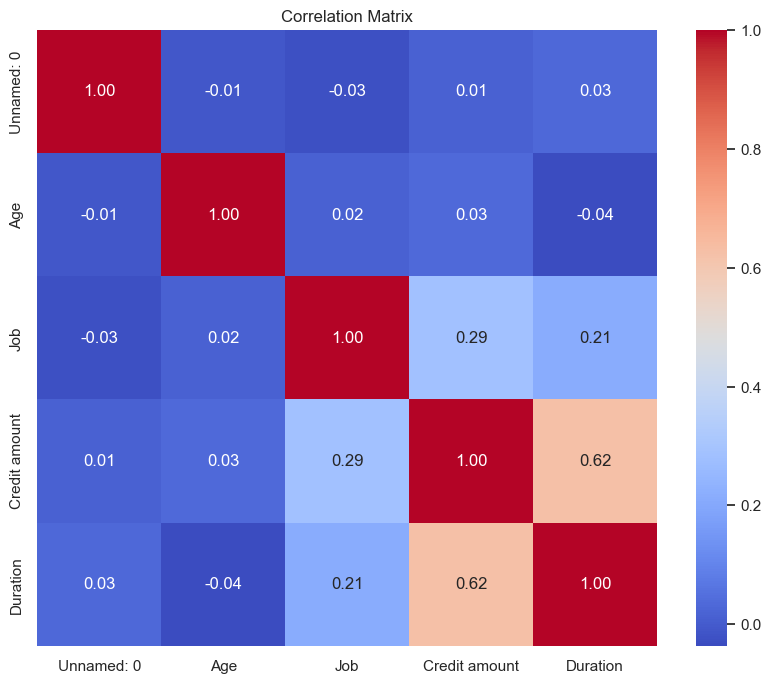

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [5]:
# Infer 'Risk' based on rules
def infer_risk(row):
    if (row["Duration"] > 36 and row["Credit amount"] > 5000) or (row["Saving accounts"] in ["no_info", "little"] and row["Age"] < 30):
        return "bad"
    else:
        return "good"

df["Risk"] = df.apply(infer_risk, axis=1)

# Label encode target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["Risk"])  # good -> 1, bad -> 0

# One-hot encode features
X = pd.get_dummies(df.drop(columns=["Risk"]), drop_first=True)

In [6]:
import joblib

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the fitted scaler
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
import joblib

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB()
}

# Dictionary to store trained models
trained_models = {}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)  # Fit the model on the training data
    trained_models[name] = model       # Save the trained model in the dictionary
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)  # Predict using the test data
    
    # Print classification report
    print(f"\n{name}:\n")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Save trained models to files for future use
for name, model in trained_models.items():
    joblib.dump(model, f"{name.replace(' ', '_').lower()}_model.pkl")

# Save the label encoder and feature columns
joblib.dump(label_encoder, "label_encoder.pkl")
feature_columns = X.columns.tolist()
joblib.dump(X.columns.tolist(), "feature_columns.pkl")



Logistic Regression:

              precision    recall  f1-score   support

         bad       0.81      0.77      0.79        60
        good       0.90      0.92      0.91       140

    accuracy                           0.88       200
   macro avg       0.85      0.84      0.85       200
weighted avg       0.87      0.88      0.87       200


Random Forest:

              precision    recall  f1-score   support

         bad       0.91      0.98      0.94        60
        good       0.99      0.96      0.97       140

    accuracy                           0.96       200
   macro avg       0.95      0.97      0.96       200
weighted avg       0.97      0.96      0.97       200


Decision Tree:

              precision    recall  f1-score   support

         bad       0.88      0.87      0.87        60
        good       0.94      0.95      0.95       140

    accuracy                           0.93       200
   macro avg       0.91      0.91      0.91       200
weighted avg     

['feature_columns.pkl']

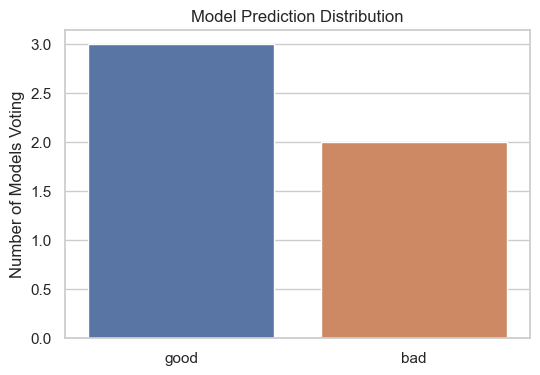

In [37]:
from collections import Counter

def show_prediction_distribution(predictions):
    counts = Counter(predictions)
    labels, values = zip(*counts.items())

    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(labels), y=list(values))
    plt.title("Model Prediction Distribution")
    plt.ylabel("Number of Models Voting")
    plt.show()

# Example:
predictions = ['good', 'bad', 'good', 'good', 'bad']
show_prediction_distribution(predictions)


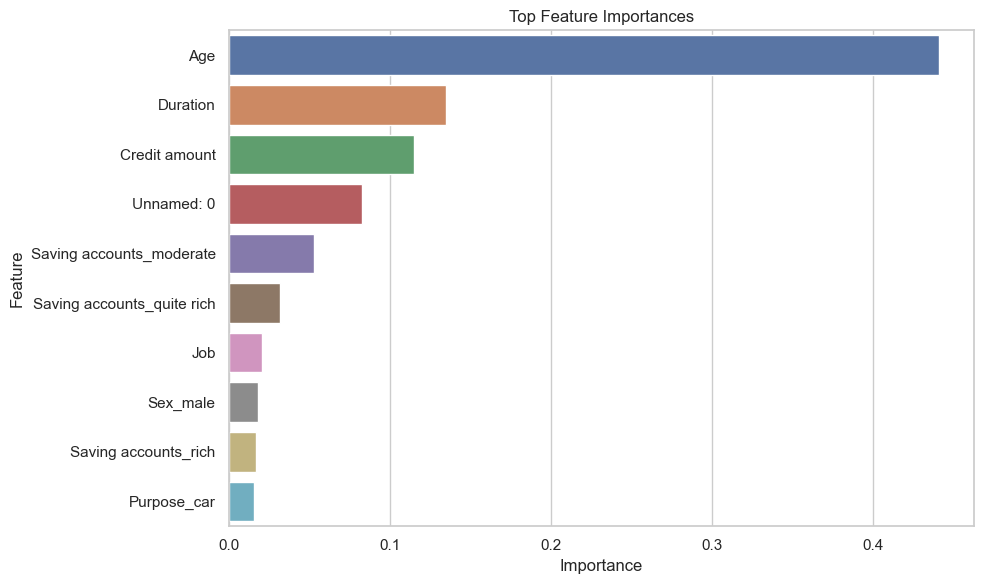

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_feature_importance(model, feature_names, top_n=10):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices][:top_n], y=np.array(feature_names)[indices][:top_n])
    plt.title("Top Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# Example:
plot_feature_importance(trained_models['Random Forest'], feature_columns)


In [27]:
# Save the label encoder and feature columns
joblib.dump(label_encoder, "label_encoder.pkl")
joblib.dump(X.columns.tolist(), "feature_columns.pkl")


['feature_columns.pkl']

In [8]:
def predict_credit_risk(new_data_dict):
    # Convert dict to DataFrame
    new_data = pd.DataFrame([new_data_dict])
    
    # Encode same as training
    new_data_encoded = pd.get_dummies(new_data)
    
    # Align columns to match training
    missing_cols = set(feature_columns) - set(new_data_encoded.columns)
    for col in missing_cols:
        new_data_encoded[col] = 0
    new_data_encoded = new_data_encoded[feature_columns] # same order

    # Scale
    new_data_scaled = scaler.transform(new_data_encoded)

    # Predict with all models
    for name, model in trained_models.items():
        prediction = model.predict(new_data_scaled)
        predicted_class = label_encoder.inverse_transform(prediction)
        print(f"{name} predicts: {predicted_class[0]}")

In [9]:
# Example input — fill with actual values from your dataset's columns
sample_input = {
    'Age': 24,
    'Sex': 'female',
    'Job': 2,
    'Housing': 'rent',
    'Saving accounts': 'little',
    'Checking account': 'little',
    'Credit amount': 4308,
    'Duration': 48,
    'Purpose': 'business'
}

predict_credit_risk(sample_input)


Logistic Regression predicts: bad
Random Forest predicts: bad
Decision Tree predicts: bad
SVM predicts: bad
Naive Bayes predicts: bad
